## Observations and Insights 

In [1]:
%matplotlib notebook

In [121]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
dfCombined = study_results.merge(mouse_metadata, on ='Mouse ID')

# Display the data table for preview
dfCombined.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


In [3]:
# Checking the number of mice.

Expected = {
            'study_dataLen': len(study_results),
            'CombinedLen' : len(dfCombined),
            'MetaCountD' : len(mouse_metadata['Mouse ID'].unique()),
            'StudyCountD' : len(study_results['Mouse ID'].unique()),
            'CombinedCountD': len(dfCombined['Mouse ID'].unique())
            }

print(Expected)

{'study_dataLen': 1893, 'CombinedLen': 1893, 'MetaCountD': 249, 'StudyCountD': 249, 'CombinedCountD': 249}


In [4]:
# interpretation: The merged dataframe contains 249 unique mouse IDs.
# This is equal to the counts of unique IDs in left and right source dataframes, which were merged on an Inner join.
# The length of the merged dataframe is also equal
# to the length of the study_results dataframe. 
# this implies that both the left and right dataframes contain the exact same 249 unique keys ('Mouse ID')

In [5]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
# copy combined dataframe with Mouse ID - Timepoint as a compound key. Group by compound key to ID duplicates

dfMultiID = dfCombined[['Mouse ID', 'Timepoint', 'Sex']].copy()  #using "Sex" as a count field, could use any column so choosing column with shortest name
dfCounts = dfMultiID.groupby(['Mouse ID', 'Timepoint']).count()
dfCounts = dfCounts.rename(columns = {'Sex': 'Timepoint_Cnt'})



In [6]:
#filter to return duplicates
dfDuplicates = dfCounts[dfCounts['Timepoint_Cnt']>1]
dfDuplicates

Timepoint_Cnt
Mouse ID Timepoint               
g989     0                      2
         5                      2
         10                     2
         15                     2
         20                     2

In [7]:
#Check that row counts make sense (expecting True):
len(dfCounts) + len(dfDuplicates) == len(dfMultiID)

True

In [8]:
# Optional: Get all the data for the duplicate mouse ID. 
    #since exactly one mouse shows duplicates, we can filter the combined df by that mouse ID:
dfDupeData = dfCombined[dfCombined['Mouse ID']=='g989']
dfDupeData

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


In [9]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
# Note there are multiple ways to do this, but filtering based on Mouse ID is the most straightforward 
dfCleaned = dfCombined[dfCombined['Mouse ID']!='g989']
len(dfCleaned) + len(dfDupeData) == len(dfCombined) # if true, confirms that the row count in dfCleaned is what was expected

True

In [10]:
# Checking the number of mice in the clean DataFrame.
# expecting 248:
len(dfCleaned['Mouse ID'].unique())

248

In [11]:
#alternatively:
#expecting True
#this avoids any hard-coding of value in case dataset changes in the future
len(dfCleaned['Mouse ID'].unique()) == len(dfCombined['Mouse ID'].unique()) - len(dfDupeData['Mouse ID'].unique())

True

## Summary Statistics

In [12]:
len(dfCleaned)

1880

In [13]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.

columns_to_keep = ['Drug Regimen','Tumor Volume (mm3)' ]
df = dfCleaned[columns_to_keep].copy() 
#Note dfCleaned shows preservation of dfCombined index, even after dropping rows. Will need to re-index if this becomes relevant


new_names = {'Tumor Volume (mm3)':'Tumor Volume'}
df = df.rename(columns = new_names)

In [14]:
agg_fns = {'Tumor Volume':['mean', 'median', 'var', 'std', st.sem]}
dfDRs = df.groupby('Drug Regimen').agg({'Tumor Volume':['mean', 'median', 'var', 'std', st.sem]})
#dfDRsem = df.groupby('Drug Regimen').agg(st.sem)
#dfOutput = 
dfDRs

Tumor Volume                                          
                     mean     median        var       std       sem
Drug Regimen                                                       
Capomulin       40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin        52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol       52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril        55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol        54.331565  52.509285  66.173479  8.134708  0.596466
Placebo         54.033581  52.288934  61.168083  7.821003  0.581331
Propriva        52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane        40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn        54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol       53.236507  51.818479  48.533355  6.966589  0.516398

In [15]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
df1 = df.groupby('Drug Regimen').mean()
df2 = df.groupby('Drug Regimen').median()
df3 = df.groupby('Drug Regimen').var()
df4 = df.groupby('Drug Regimen').std()
df5 = df.groupby('Drug Regimen').agg(st.sem)

df1 = df1.rename(columns={'Tumor Volume': 'Mean Tumor Volume'})
df2 = df2.rename(columns={'Tumor Volume': 'Median Tumor Volume'})
df3 = df3.rename(columns={'Tumor Volume': 'Tumor Volume Variance'})
df4 = df4.rename(columns={'Tumor Volume': 'Tumor Volume Std Dev'})
df5 = df5.rename(columns={'Tumor Volume': 'Tumor Volume Std Error'})


dfSummaryStats = df1.merge(df2, on = 'Drug Regimen').merge(df3, on='Drug Regimen').merge(df4, on='Drug Regimen').merge(df5, on='Drug Regimen')
dfSummaryStats


,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std Dev,Tumor Volume Std Error
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [16]:
# Using the aggregation method, produce the same summary statistics in a single line
df.groupby('Drug Regimen').agg({'Tumor Volume':['mean', 'median', 'var', 'std', st.sem]})

Tumor Volume                                          
                     mean     median        var       std       sem
Drug Regimen                                                       
Capomulin       40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin        52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol       52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril        55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol        54.331565  52.509285  66.173479  8.134708  0.596466
Placebo         54.033581  52.288934  61.168083  7.821003  0.581331
Propriva        52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane        40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn        54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol       53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

In [17]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pandas.

dfCleaned.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22


<IPython.core.display.Javascript object>


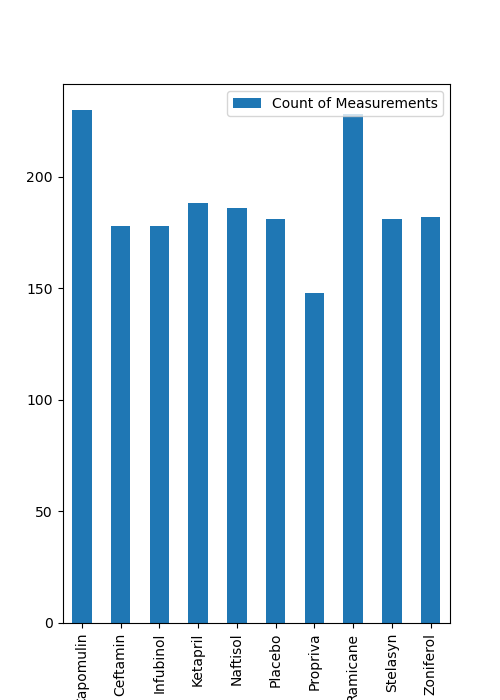

In [107]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
    #Pandas Method
dfN = dfCleaned[['Drug Regimen', 'Sex']].copy()
dfN_per_Drug = dfN.groupby('Drug Regimen').count()
dfN_per_Drug=dfN_per_Drug.rename(columns = {'Sex':'Count of Measurements'})

dfN_per_Drug.plot(y=0, kind='bar', figsize=(5,7))
plt.savefig("../Images/MeasurementsPandasBar.png")


In [88]:
# Generate a bar plot showing the total number of measurements taken on each drug regimen using pyplot.
    
    #Pyplot Method
    
    
#Reset index only if we haven't done so already
if len(dfN_per_Drug.columns) == 1:
    dfN_per_Drug.reset_index(inplace=True)

x_axis = np.arange(len(dfN_per_Drug[['Drug Regimen']]))
y_axis = dfN_per_Drug.iloc[:,1]


plt.bar(x_axis, y_axis, color='b', align='center')

# Create the ticks for our bar chart's x axis
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, dfN_per_Drug.iloc[:,0])

# Set the limits of the x axis
plt.xlim(-0.75, len(x_axis)-0.25)

# Set the limits of the y axis
plt.ylim(0, max(y_axis)+50)

# Give the chart a title, x label, and y label
plt.title("Measurements per Regimen")
plt.xlabel("Regimen")
plt.ylabel("Count of Measurements")
plt.savefig("../Images/MeasurementsPyplotBar.png")
plt.show()

## pie chart

In [124]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
    #taking cleaned dataframe and group by mouse ID to retrn the max of sex
    
dfSex = dfCleaned[['Mouse ID', 'Sex']].copy()
dfSex1 = dfSex.groupby('Mouse ID').max()  #condenses rows to one per Mouse ID

#Reset index only if we haven't done so already
if len(dfSex1.columns) == 1:
    dfSex1.reset_index(inplace=True)


dfSex2 = dfSex1.groupby('Sex').count()
#Reset index only if we haven't done so already
if len(dfSex2.columns) == 1:
    dfSex2.reset_index(inplace=True)
# Rename column for mouse count
new_names = {'Mouse ID':'Mouse_Cnt'}
dfSex2 = dfSex2.rename(columns = new_names)

In [103]:
#Convert dataframe columns into series
x_axis = dfSex2['Sex'].squeeze()
y_axis = dfSex2['Mouse_Cnt'].squeeze()

pandas.core.series.Series

In [104]:
#Set up names for arguments
colors =['lightcoral', 'lightskyblue']

<IPython.core.display.Javascript object>


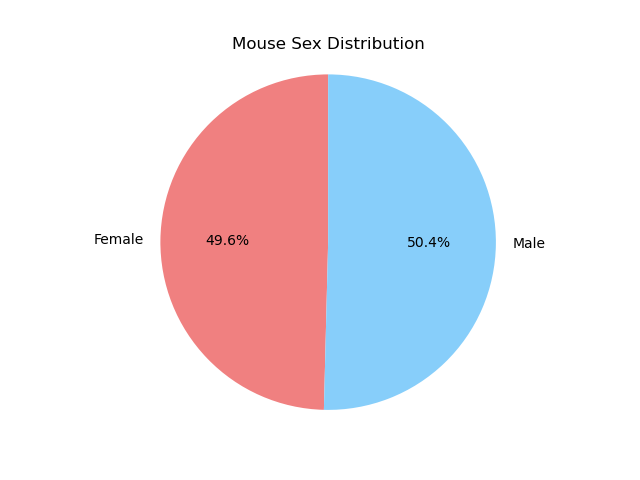

In [108]:
#Put the pie chart together
plt.title("Mouse Sex Distribution")
plt.pie(y_axis, labels=x_axis, colors=colors, autopct='%1.1f%%', startangle = 90)
plt.axis('equal')
plt.savefig("../Images/MeasurementsPyplotPie.png")
plt.show()

## Quartiles, Outliers and Boxplots

In [134]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
columns_to_keep = ['Mouse ID', 'Timepoint']
dfTimesPerMouse = dfCleaned[columns_to_keep].copy()
dfMaxTimes = dfTimesPerMouse.groupby('Mouse ID').max()


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
dfUltimateMeasures = dfMaxTimes.merge(dfCleaned, on = ['Mouse ID','Timepoint'], how='left')

248

In [137]:
# Put treatments into a list for for loop (and later for plot labels)
treatments = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
TumorVolumes=[]


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

list

In [23]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [24]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [25]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [26]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
